# Display ensamble members in the Featurespace


## Import libraries

In [2]:
from src.preproces import *
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import re

In orther to performe classification we will express each ensamble member as a point observation in the featurespace. To do this we will start by creating multivariate time series. The feature of the time series names that identify the model run is the bold part of our example name:*tas_day_ACCESS-ESM1-5_ssp370_**r28i1p1f1**_gn_20150101-21001231.nc*.
Therefore we use the re library to search for matches in tas and pr files with the pattern r'r\d+' where \d signifies "digit".

#### NB: Only run once

In [65]:
file_handler = Handle_Files()

data_dir = '/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/'
var_names = ['tas', 'pr']
ssp_names = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

# Regular expression pattern to match the dynamic part
pattern = r'r\d+'

multivariate_names = {}
for ssp_name in ssp_names:
    tas_dir = Path('/'.join([data_dir, var_names[0], ssp_name]))
    pr_dir = Path('/'.join([data_dir, var_names[1], ssp_name]))
    tas_file_names = file_handler.get_all_filenames_in_dir(tas_dir)
    pr_file_names = file_handler.get_all_filenames_in_dir(pr_dir)

    multivariate_names_ssp = []

    # Iterate over the tas_files and pr_files
    for tas_file_name in tas_file_names:
        # Extract the dynamic part from the tas_file
        match = re.search(pattern, tas_file_name)
        if match:
            dynamic_part = match.group()
            
            # Find the matching pr_file
            for pr_file_name in pr_file_names:
                if dynamic_part in pr_file_name:
                    tas_ds = (file_handler
                              .read_netcdf_to_xr(directory=tas_dir, file_name=tas_file_name)
                              .drop('height')
                              .sel(year=slice(None,'2100'))
                              )
                    pr_ds = (file_handler
                             .read_netcdf_to_xr(directory=pr_dir, file_name=pr_file_name)
                             .sel(year=slice(None,'2100'))
                            )
                    
                    multivariate_ds = xr.merge([tas_ds, pr_ds])

                    mv_filename = '_'.join(['mv_ACCESS-ESM1-5', 
                                            ssp_name, 
                                            tas_file_name.split('_')[4], 
                                            'gn_20150101-21001231_global_yearly_climatology.nc'])
                    file_handler.save_dataset_to_netcdf(multivariate_ds, 
                                                        directory='/'.join([data_dir, 'multivariate', ssp_name]), 
                                                        file_name=mv_filename)  
                    multivariate_names_ssp.append(mv_filename)
                    break
    
    multivariate_names[ssp_name] = multivariate_names_ssp

In this section, we are creating a scatter plot to visualize the relationship between precipitation and temperature for different years and scenarios.

We iterate over the scenarios and load the corresponding multivariate datasets. For each dataset, we calculate the mean precipitation and temperature values for every $10 \pm 5$ years. The resulting scatter plot allows us to observe the relationship between precipitation and temperature over time and across different scenarios.

This visualization helps us understand how precipitation and temperature are related and how they vary under different climate scenarios. It can provide insights into climate patterns and potential impacts on the environment.

In [9]:
def plot_scatter(data_dir, ssp_names, years, pm):

    n_samples_to_plot = len(years)
    
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique))

    n_rows = lambda x: (x - 1) // 4 + 1 
    n_rows = n_rows(n_samples_to_plot)
    n_cols = int(np.ceil(n_samples_to_plot/n_rows))

    fig, axs = plt.subplots(n_rows, n_cols, sharey=True, sharex=True, figsize=(3*n_cols, 5*n_rows))
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(ssp_names)))
    color_map = dict(zip(ssp_names, colors))

    for ssp_name in ssp_names:
        ssp_dir = os.path.join(data_dir, ssp_name)
        file_list = os.listdir(ssp_dir)

        for file_name in file_list:
            file_path = os.path.join(ssp_dir, file_name)
            ds = xr.open_dataset(file_path)

            indx = 0
            for i in range(n_rows):
                for j in range(n_cols):
                    if i*n_cols + j >= n_samples_to_plot:
                        break
                    ds_years = ds.sel(year=slice(years[indx]-pm, years[indx]+pm))
                    mean_pr = ds_years.pr.mean(dim='year')
                    mean_tas = ds_years.tas.mean(dim='year')

                    
                    if n_samples_to_plot <= 4:
                        ax = axs[j]
                    else:
                        ax  = axs[i, j]
                        
                    ax.scatter(mean_pr, mean_tas, 
                               color=color_map[ssp_name], alpha=0.7,
                               label=ssp_name)
                    indx += 1

    indx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if i*n_cols + j >= n_samples_to_plot:
                break
            if n_samples_to_plot <= 4:
                ax = axs[j]
            else:
                ax = axs[i, j]
            if j == 0:
                ax.set_ylabel('Temperature (K)') 
            if i == n_rows-1:
                ax.set_xlabel('Precipitation')
            lower = years[indx]-pm if indx > 0 else 2015
            ax.set_title(fr'Year {lower}-{years[indx]+pm}')
            legend_without_duplicate_labels(ax)
            indx += 1

    plt.show()

The questions for these clusters is, how early can we draw the lines between the clusters?

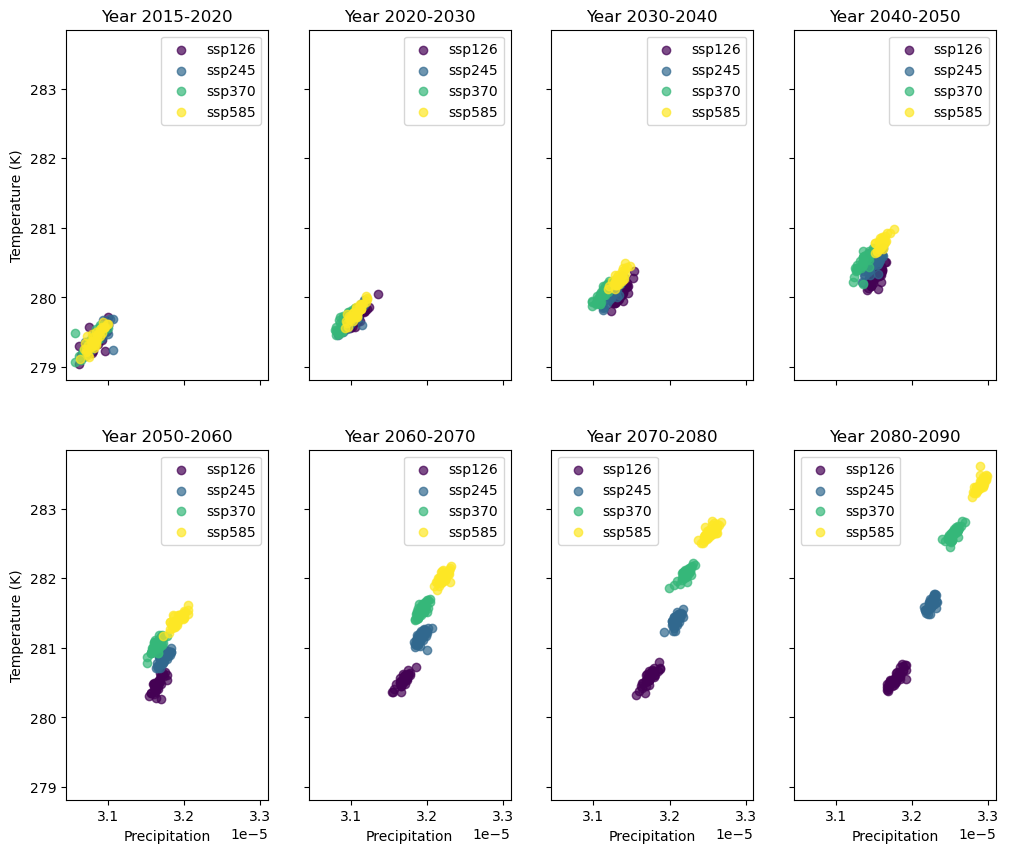

In [5]:
data_dir = '/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/multivariate/'

ssp_names = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
n_samples_to_plot = 8 # choose an even number
years = [indx*10 + 2015 for indx in range(n_samples_to_plot)]

plot_scatter(data_dir, ssp_names, years, 5)

We can simplify this task by choosing only the two pathways that ultimatly is furthest appart, that is: ssp126 and ssp585

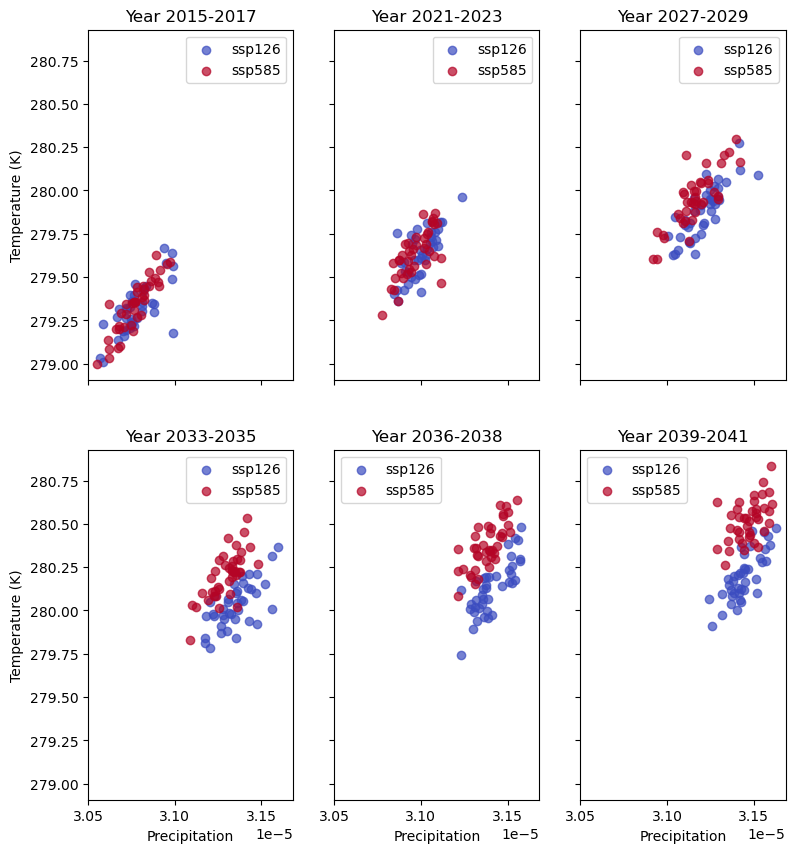

In [11]:
ssp_names = ['ssp126', 'ssp585']
n_samples_to_plot = 8 # choose an even number
years = [indx*5 + 2015 for indx in range(n_samples_to_plot)]
years = [2016, 2022, 2028, 2034, 2037, 2040]
 
plot_scatter(data_dir, ssp_names, years, 1)